In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('churn_false.csv')
df

,Unnamed: 0,Phone_Number,Account_Length,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,...,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Churn,Cluster,PCA1,PCA2,Day_Eve_Charge_Ratio,Night_Intl_Charge_Ratio
0,0,382-4657,128,25,265.1,110,45.07,197.4,99,16.78,...,10.0,3,2.70,1,False,1,-1.130000,-0.261887,2.685936,4.077778
1,1,371-7191,107,26,161.6,123,27.47,195.5,103,16.62,...,13.7,3,3.70,1,False,1,-1.906776,-0.641235,1.652828,3.094595
2,2,358-1921,137,0,243.4,114,41.38,121.2,110,10.30,...,12.2,5,3.29,0,False,1,-2.791505,-1.783122,4.017476,2.224924
3,3,330-6626,75,0,166.7,113,28.34,148.3,122,12.61,...,10.1,3,2.73,3,False,1,-3.283894,-1.073900,2.247423,3.080586
4,4,391-8027,118,0,223.4,98,37.98,220.6,101,18.75,...,6.3,6,1.70,0,False,1,-2.080675,0.139076,2.025600,5.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31689,36072,796-5759,228,0,222.8,92,29.82,280.0,202,22.28,...,9.6,2,2.89,2,False,1,0.028126,1.697858,1.338420,7.643599
31690,36073,779-7579,62,0,228.8,92,29.88,292.8,92,26.88,...,20.2,2,2.82,8,False,1,-0.400837,-0.165286,1.111607,3.411348
31691,36074,789-9756,222,0,228.2,60,22.82,229.8,289,28.26,...,6.2,2,2.62,2,False,1,-1.100422,-0.297205,0.807502,0.870229
31692,36075,798-5885,88,0,282.2,222,82.88,208.8,220,22.82,...,9.8,8,2.82,8,False,0,1.591961,1.143648,3.631902,7.333333


In [3]:
# Ensure 'Churn' column is properly formatted
df['Churn'] = df['Churn'].astype(int)

# Select relevant numerical columns for clustering
numerical_cols = [
    'Account_Length', 'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 
    'Eve_Mins', 'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 
    'Night_Charge', 'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls'
]

X = df[numerical_cols]

In [4]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [6]:
# Hierarchical clustering
linked = linkage(X_pca, method='ward')

In [7]:
# Determine the clusters
df['Cluster'] = fcluster(linked, t=3, criterion='maxclust')

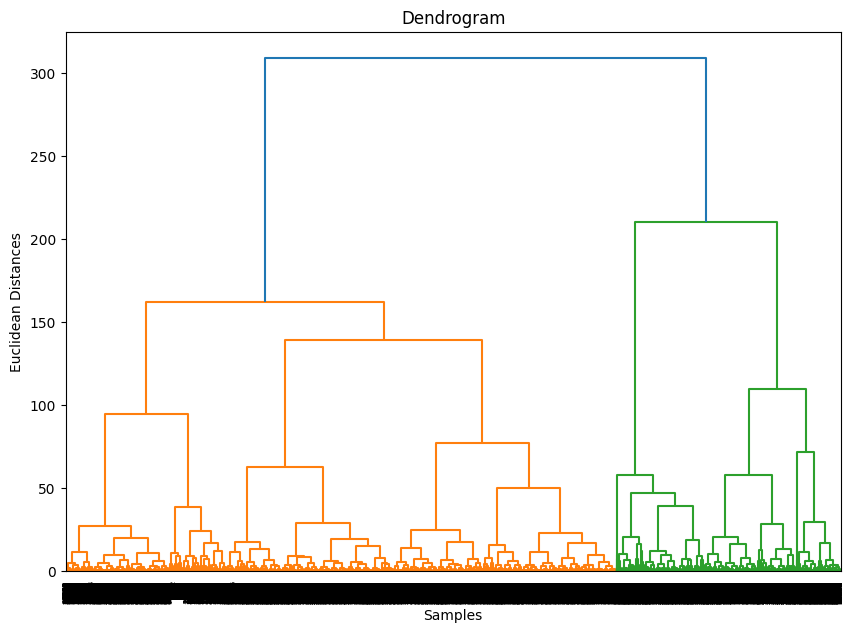

In [8]:
# Visualize the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Euclidean Distances')
plt.show()

In [9]:
# Calculate Customer Lifetime Value (CLV)
df['CLV'] = df['Day_Charge'] + df['Eve_Charge'] + df['Night_Charge'] + df['Intl_Charge']

In [10]:
# Define cluster names based on your analysis
cluster_names = {
    1: 'Potential Low Value Customers',
    2: 'Potential Medium Value Customers',
    3: 'Potential High Value Customers'
}

# Map clusters to descriptive names
df['Cluster_Name'] = df['Cluster'].map(cluster_names)

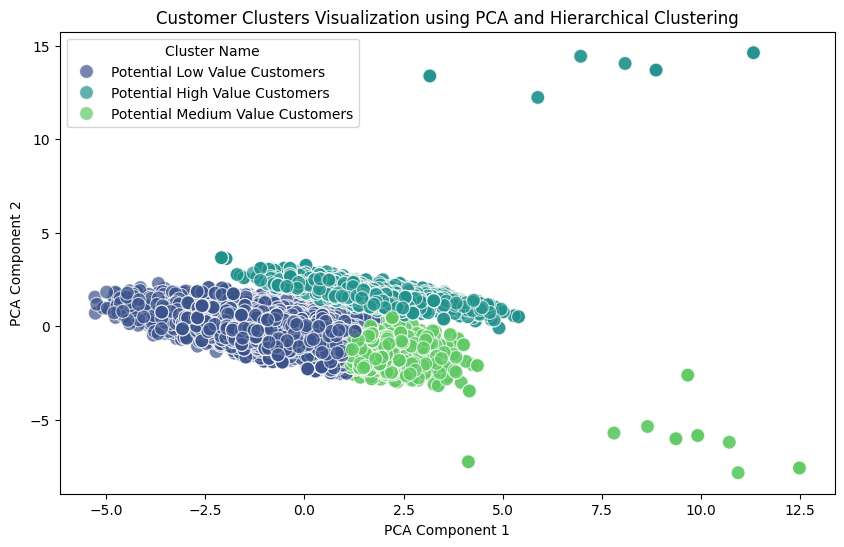

In [11]:
# Visualizing the clusters using PCA components
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue='Cluster_Name', data=df, palette='viridis', s=100, alpha=0.7)
plt.title('Customer Clusters Visualization using PCA and Hierarchical Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster Name', loc='best')
plt.show()

In [12]:
# Cluster analysis: describe statistics and CLV
cluster_analysis = {}
for i in range(1, 4):
    cluster_name = cluster_names.get(i, f'Cluster {i}')
    cluster_data = df[df['Cluster'] == i][numerical_cols].describe()
    cluster_clv_mean = df[df['Cluster'] == i]['CLV'].mean()
    churn_rate = df[df['Cluster'] == i]['Churn'].mean() * 100  # Convert to percentage
    cluster_analysis[cluster_name] = {
        'Data Description': cluster_data,
        'Average CLV': cluster_clv_mean,
        'Churn Rate': churn_rate
    }

In [13]:
# Count the number of records in each cluster
cluster_counts = df['Cluster_Name'].value_counts()

In [14]:
# Results
print("Cluster Analysis Summary:")
for cluster_name, analysis in cluster_analysis.items():
    print(f"\n{cluster_name}:\n")
    print(analysis['Data Description'])
    print(f"Average CLV: {analysis['Average CLV']:.2f}")
    print(f"Churn Rate: {analysis['Churn Rate']:.2f}%")

print("\nNumber of Records in Each Cluster:")
print(cluster_counts)

Cluster Analysis Summary:

Potential Low Value Customers:

       Account_Length  VMail_Message      Day_Mins     Day_Calls  \
count    22530.000000   22530.000000  22530.000000  22530.000000   
mean       136.302841      10.222725    227.760874    137.361385   
std         89.755546      19.211338     48.066061     79.154519   
min          1.000000       0.000000     62.300000     20.000000   
25%         44.000000       0.000000    220.600000     82.000000   
50%         99.000000       0.000000    226.300000     99.000000   
75%        222.000000      22.000000    244.300000    220.000000   
max        329.000000     112.000000    444.400000    329.000000   

         Day_Charge      Eve_Mins     Eve_Calls    Eve_Charge    Night_Mins  \
count  22530.000000  22530.000000  22530.000000  22530.000000  22530.000000   
mean      34.851087    238.592802    139.493165     23.012402    238.777986   
std       19.257275     35.162127     79.199832      4.440217     33.809815   
min        6